# RNetwork Training

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import torch
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils
import envs.walker_utils as walker_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.dataset import RNetPairsSplitDataset
from exploration_buffer import ExplorationBuffer
from rnet.utils import *

from matplotlib import colors
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config Utils

In [4]:
cfg_path = f"../conf/config.yaml"

env_name = 'maze_U4rooms'

cfg = OmegaConf.load(cfg_path)
#cfg.exploration_buffer.data_dir = "/checkpoint/linamezghani/offline-gcrl/data/walker/proto/buffer"
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')

cfg = OmegaConf.merge(cfg, env_cfg)

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cuda:1")

In [5]:
env = envs.make_env(cfg.env, space_info)

points = env.generate_points(30, random=False)

## RNet dataset

In [6]:
print(cfg.rnet.dataset)

{'thresh': 10, 'neg_thresh': 0, 'in_traj_ratio': 0.5, 'symmetric': True, 'valid_ratio': 0.05, 'num_pairs': {'train': 500000, 'val': 100000}}


In [7]:
cfg.rnet.dataset.thresh = 10
cfg.rnet.dataset.symmetric = False

expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

dataset = RNetPairsSplitDataset(cfg.rnet.dataset, expl_buffer)

loading exploration buffer


/private/home/linamezghani/.conda/envs/polybeast/lib/python3.7/site-packages/omegaconf/resolvers/__init__.py:13: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  "The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573"


## Train RNet

In [8]:
cfg.rnet.model.remove_velocity = True

model = RNetModel(cfg.rnet.model, space_info)
model = model.to(device)

print(model)

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [9]:
cfg.rnet.train.num_epochs = 3

stats = train(cfg.rnet.train, model, dataset, device)

rnet epoch 0 - train loss 0.36,  acc 0.87 - val loss 0.23,  acc 0.91
rnet epoch 1 - train loss 0.20,  acc 0.92 - val loss 0.18,  acc 0.93
rnet epoch 2 - train loss 0.18,  acc 0.93 - val loss 0.17,  acc 0.94


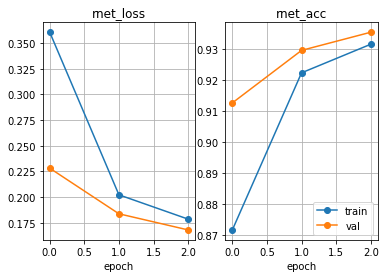

In [10]:
epochs = list(stats.keys())

new_stats = {}
for epoch in epochs:
    for phase in stats[epoch]:
        if not phase in new_stats:
            new_stats[phase] = {}
        for stat, v in stats[epoch][phase].items():
            if not stat in new_stats[phase]:
                new_stats[phase][stat] = []
            if isinstance(v, torch.Tensor):
                v = v.item()
            new_stats[phase][stat].append(v)

fig, ax = plt.subplots(1, 2)
i = 0
for stat in ['rnet_loss', 'rnet_acc']:
    for phase in ['train', 'val']:
        ax[i].plot(epochs, new_stats[phase][stat], label=phase, marker='o')
    ax[i].grid()
    ax[i].set_title(stat)
    ax[i].set_xlabel('epoch')
    i += 1
ax[1].legend()
plt.show()

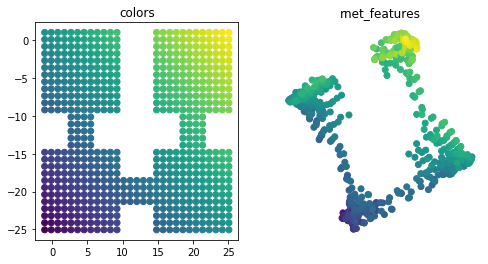

In [15]:
model.eval()
model.to("cpu")
fig = env.plot_embeddings(model, points['state'][:, :], points['state'][:, :],
                          show_colors=True)

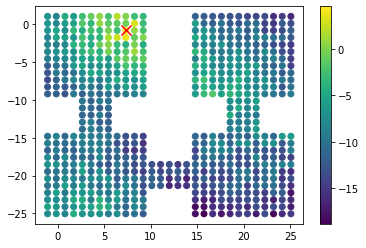

In [12]:
i = np.random.randint(0, points['state'][:, :3].shape[0])
fig = env.plot_values(model, points['state'][:, :3][i], points['state'][:, :3][i], points['state'][:, :3],
                      points['state'][:, :3])

In [18]:
model.to(device)
embs = embed_expl_buffer(expl_buffer, model, device)
print(embs.shape)



embed exploration buffer: 100%|██████████| 10000/10000 [00:03<00:00, 3191.84it/s]

torch.Size([10000, 1001, 16])


## Build Memory

In [44]:
cfg.rnet.memory.skip = 1
cfg.rnet.memory.skip_traj = 0.01
cfg.rnet.memory.capacity = 1000
cfg.rnet.memory.directed = True

In [45]:
memory = RNetMemory(cfg.rnet.memory, space_info, model.feat_size, device)

model = model.to(device)
memory = build_memory(cfg.rnet.memory, space_info, model, expl_buffer, device)
memory.compute_dist()

Updating Memory: 100%|██████████| 10000/10000 [01:30<00:00, 110.65it/s]


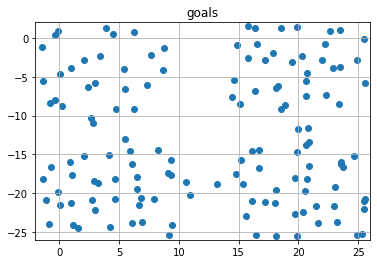

In [46]:
env.set_goals(memory.get_goals())
fig = env.plot_goals()

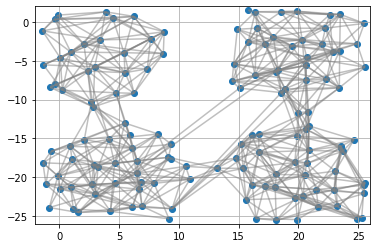

In [57]:
fig = env.plot_graph(memory)

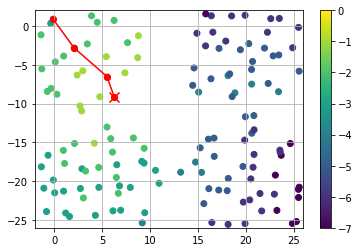

In [58]:
fig = env.plot_graph_dist(memory)

## Test clustering

In [51]:
from scipy.cluster.hierarchy import fclusterdata

In [63]:
embs = rnet_utils.embed_expl_buffer(expl_buffer, model, device)

embed exploration buffer: 100%|██████████| 10000/10000 [00:03<00:00, 2661.89it/s]


In [1]:
embs.shape

NameError: name 'embs' is not defined

In [78]:
expl_buffer.states.shape

(10000, 1001, 7)

In [82]:
states = expl_buffer.states.reshape((-1, 7))
x = states[:, 0]
y = states[:, 1]

In [62]:
import rnet.utils as rnet_utils

In [309]:
N = 20000

In [300]:
for t in [0.1,0.2, 0.25]:
    clus = fclusterdata(embs[:N], t=t, criterion='distance')#, metric=rnet_dist)
    print(t, np.unique(clus).shape[0])

0.1 11145
0.2 1327
0.25 345


In [310]:
clus = fclusterdata(embs[:N], t=0.2, criterion='distance')#, metric=rnet_dist)
print(t, np.unique(clus).shape[0])

0.25 1327


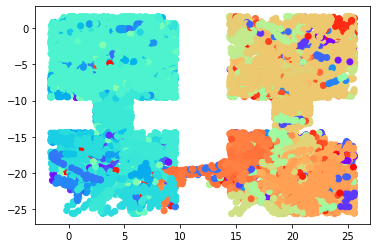

In [311]:
plt.scatter(x[:N], y[:N], c=clus, cmap = plt.cm.rainbow)
plt.show()

In [221]:
print(device)

cuda:1


In [244]:
model.to(device)
def rnet_dist(a, b):
    if isinstance(a, np.ndarray):
        a = torch.tensor(a).float()
    if isinstance(b, np.ndarray):
        b = torch.tensor(b).float()
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        rnet_val = model.compare_embeddings(a.unsqueeze(0), b.unsqueeze(0), batchwise=True)[:, 0].item()
    return max(- rnet_val, 0)

In [211]:
rnet_dist(embs[10], embs[200])

7.040764808654785

## Compute NN

In [285]:
model.to(device)
NN = compute_NN(expl_buffer, model, memory, device)

computing NN:  53%|█████▎    | 5279/10001 [23:36<21:20,  3.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

computing NN: 100%|██████████| 10001/10001 [44:48<00:00,  3.72it/s]


## Save

In [286]:
exp_name = 'walker_thresh2-velo'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)

save(save_dir, model, memory, NN)

Saving rnet objects to  /checkpoint/linamezghani/offline-gcrl/rnet/walker_thresh2-velo


In [20]:
avg_distance = 0

for i in tqdm(range(expl_buffer.states.shape[0])):
    for j in range(expl_buffer.states.shape[1]):
        NN_state = memory.states[NN[i, j]]
        avg_distance += np.linalg.norm(NN_state[:2] - expl_buffer.states[i, j, :2])
        
avg_distance /= (expl_buffer.states.shape[0] * expl_buffer.states.shape[1])
print(f"Average distance from state to its NN: {avg_distance:.2f}")

100%|██████████| 10000/10000 [01:06<00:00, 150.26it/s]

Average distance from state to its NN: 1.42


In [312]:
N = 100


traj = expl_buffer.states[:N].reshape((-1, expl_buffer.states.shape[-1]))
flat_NN = NN[:N].flatten()
classes = np.unique(flat_NN)
np.random.shuffle(classes)
c = [np.where(flat_NN[j] == classes)[0][0] for j in range(len(traj))]

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, len(classes), 1), cmap.N)

sc = plt.scatter(traj[:, 0], traj[:, 1], c=c, cmap=cmap, norm=norm, edgecolor='none')
plt.colorbar(sc)
plt.xlim(env.xlim)
plt.ylim(env.ylim)
plt.show()

NameError: name 'NN' is not defined